# Behler-Parrinello Symmetry Functions

In this notebook, I will create Behler-Parrinello and ANI nerual networks using atom-centered symmetry functions. The symmetry functions will alow us to ensure that the observables (such as energy, forces) are invariant to translations and rotations.

## Importing PyTorch and Libraties

I begin by import PyTorch and required libraries.

In [58]:
%%capture
!pip install pytorch-lightning > /dev/null   #installing PyTorch lightning

import IPython
print(IPython.__version__)

import sys
print(sys.executable)

from src import plot_pairwise_vector

import math
from typing import Sequence, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

%load_ext IPython.extensions.autoreload
%autoreload 2

## Symmetry Functions

Machine learning models often use Cartesian coordinates $(x,y,z)$ to describe atomic structures. However, Cartesian coordinates are not ideal inputs for neural networks because rotating or translating molecule changes the coordinates changing the physical system. Since molecular energies must remain invariant under rotations and translations, the input representation should reflect this invariance. 

Symmetry functions solve this problem by transforming atomic coordinates into descriptors that depend only on relative atomic arrangements. These descriptors remain unchanged when the molecule is translated or rotated. As a result, the neural network learns the physics of the system rather than the arbitary choice of coordinate system.

[Behler and Parrinello](https://doi.org/10.1103/PhysRevLett.98.146401) (2007) introduced a set of symmetry functions that describe the local environment around each atom. These functions include a cutoff function, radial symmetry functions, and angular symmetry functions. 


**Cutoff function**


Interaction between atoms are only considered within a finite distance $R_c$. The cutoff function smoothly reduces interactions to zero at the cutoff distance:

$$ f_c(R_{ij})= \begin{cases} \frac{1}{2}\left[\cos\left(\frac{\pi R_{ij}}{R_c}\right) + 1\right], & R_{ij} \leq R_c \\ 0, & R_{ij} > R_c \end{cases}$$

Here $R_{ij}$ is the distance between atoms $i$ and $j$, and $R_c$ is the cutoff distance. This smooth decay avoids discontinuties and ensures stable training. 

**Radial symmetry function**

The radial symmetry function describes how neighbouring atoms are distributed at different distances from atom $i$:

$$ G_{i}^{1} = \sum_{j\neq i} e^{-\eta (R_{ij} - R_s)^2} f_c(R_{ij})$$

Each term is a Gaussian centered at distance $R_{c}$, and the parameter $\eta$ controls its width. Using multiple values of $R_s$ and $\eta$ allows the network to detect detailed radial structure around each atom. 

**Angular symmetry function**

Radial information alone does not fully describe atomic environments. Angular symmetry functions include information bond angles formed by atom triplets $(i,j, k)$:

$$ G_{i}^{2} = 2^{1-\zeta} \sum_{j, k\neq i}^{\text{all}} (1 + \lambda \cos\theta_{ijk}) \times e^{-\eta(R_{ij}^2 + R_{ij}^2 + R_{jk}^2)} f_c(R_{ij}) f_c(R_{ik}) f_c(R_{jk})  $$

Here:
* $\theta_{ijk} = \frac{\mathbf{R}_{ij}\cdot \mathbf{R}_{ik}}{R_{ij}R_{ik}}$ is the angle formed by atoms $j-i-k$
* $\lambda= \pm 1$ selects different angular regions
* $\zeta$ controls angular resolution
* $\eta$ controls radial localization


**ANI Angular Symmetry Function**

The ANI model introduced a modified angular symmetry functions (It was developed by [Smith $\textit{et al.}$](https://doi.org/10.1039/C6SC05720A) in 2017):

$$ G_{i}^{2} = 2^{1-\zeta} \sum_{j, k\neq i}^{\text{all}} (1 + \cos(\theta_{ijk} - \theta_{s})) \times e^{-\eta \Big(\frac{R_{ij} + R_{ij}}{2} - R_{s}\Big)^2} f_c(R_{ij}) f_c(R_{ik}) $$


Here, $\theta_s$ is a parameter that allows for shifts in the angular environment and $R_s$ allows for calculating the angular environment in radial shells by shifting the center of the Gaussians. 

## Defining Symmetry Functions

In `bp_symmetry.py`, I define the four radial functions:

* `pairwise_vector`: Distance function for calculating distances between each atom.
* `symmetry_function_g1` : BP radial symmetry function.
* `symmetry_function_g2` : BP angular symmetry function.
* `symmetry_function_g2ani` : ANI angular symmetry function.

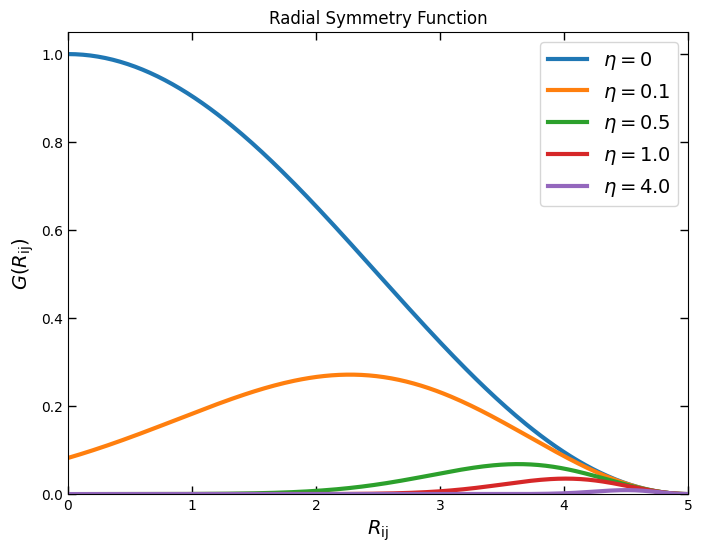

In [ ]:
Rij = np.linspace(0, 6, 300)
Rc = 1.0
etas = [0, 0.1, 0.5, 1.0, 4.0]

plot_pairwise_vector(Rij, Rc, etas)